In [11]:
from env import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Intro
This notebook contains the implementation for the Monte Carlo control method. <br><br>
In brief, Monte Carlo uses a full episode in order to update the value function in the right direction. So, for a given number of episodes, the algorithm plays a full episode and updates the values for the states that it has seen based on the reward that it received at the end of the episode. 

### First, some helper functions

#### Finding the optimal policy and state-value function given Q

In [12]:
def find_optimal_policy_and_value_function(Q):
    optimal_Pi = {}
    optimal_V = {}

    for state, action_values in Q.items():
        best_action = max(action_values, key=lambda k: action_values[k])
        optimal_Pi[state] = best_action

        best_value = max(action_values.values())
        optimal_V[state] = best_value

    return optimal_Pi, optimal_V

#### The functions used for plotting the policy and value function

In [14]:
def plot_policy(policy):

    dealer_values = np.arange(1, 11)
    player_values = np.arange(1, 22)

    actions = [
        ['stick' if policy.get((d, p), 0) else 'hit' for d in dealer_values]
        for p in player_values
    ]

    df = pd.DataFrame(actions, columns=dealer_values, index=player_values)
    df.columns.name = 'Dealer'
    df.index.name = 'Player'
    print(df)


def plot_value_function(V):
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(121, projection='3d')

  dealer_values, player_values = zip(*[(state[0], state[1]) for state, _ in V.items()])
  _xx, _yy = np.meshgrid(dealer_values, player_values)
  x, y = _xx.ravel(), _yy.ravel()
  top = np.array([V.get((xi, yi), 0) for xi, yi in zip(x, y)])
  bottom = np.zeros_like(top)
  width = 1
  depth = 1

  ax.bar3d(x, y, bottom, width, depth, top, shade=True) 
  ax.set_zlim(-1, 1)
  ax.set_xlabel('Dealer card')
  ax.set_ylabel('Player sum')

### The actual code for the Monte Carlo control implementation

In [15]:
# returns an epsilon greedy chosen action given the action-value function
# N_0 is a constant, N_s is the dictionary containing how many times each state has been visited
def epsilon_greedy(Q, N_0, N_s, state):
    action_values = Q[state]
    epsilon = N_0 / (N_0 + N_s.get(state, 0))

    # the second check makes sure the algorithm chooses an action
    # at random when the values are the same (rather than always choosing HIT)
    if epsilon > random.uniform(0, 1) or action_values[0] == action_values[1]:
        return random.choice([action.value for action in Action])

    return max(action_values, key=lambda k: action_values[k])

In [48]:
# returns the action-value function found by MC
def monte_carlo_control(env: Env, num_episodes=100, N_0=100):
    # the action-value function, a dictionary with the entries as state: {action, value}
    Q = initializeQ()
    # the number of times each state is visited
    N_s = {}
    # the number of times each (state, action) pair is visited
    N_sa = {}
    wins = 0

    for i in range(num_episodes):
        # generate episode with epsilon-greedy policy
        dealer_sum = NewCard(firstCard=True).get_value()
        player_sum = NewCard(firstCard=True).get_value()
        terminated = False
        episode = []
        G_t = 0

        while not terminated:
            state = (dealer_sum, player_sum)
            N_s[state] = N_s.get(state, 0) + 1
            N_sa[(state, action)] = N_sa.get((state, action), 0) + 1
            
            action = epsilon_greedy(Q, N_0, N_s, state)
            episode.append((state, action))
            dealer_sum, player_sum, reward, terminated = env.step(
                dealer_sum, player_sum, action
            )
            G_t += reward

        wins += reward == 1
        if i % (num_episodes / 10) == 0 and i > 0:
            print("Episode: %d, score: %f" % (i, (float(wins) / i * 100.0)))

        for state, action in episode:
            alpha = 1 / N_sa[(state, action)]
            Q[state][action] = Q[state][action] + alpha * (G_t - Q[state][action])

    return Q

In [18]:
env = Env()

We can now find the optimal policy and optimal value function by running Monte Carlo for a given number of steps.

In [19]:
Q0 = monte_carlo_control(env, 10000)
optimal_Pi_Q0, optimal_V_Q0 = find_optimal_policy_and_value_function(Q0)

Episode: 1000, score: 45.600000
Episode: 2000, score: 43.200000
Episode: 3000, score: 43.766667
Episode: 4000, score: 44.950000
Episode: 5000, score: 45.160000
Episode: 6000, score: 45.333333
Episode: 7000, score: 45.542857
Episode: 8000, score: 46.000000
Episode: 9000, score: 46.388889


After 10000 episodes, it finds that the states where the player has a sum close to 21 are the best (the player can just stick and it is a high chance that the dealer will lose). <br><br>
The worst states are were the sum of the player's cards is small and the dealer has a high card. If you choose to stick in this situation, it is a high chance the dealer will not go bust, but if you choose to hit, it is a pretty big chance you will go bust by extracting a red card. 

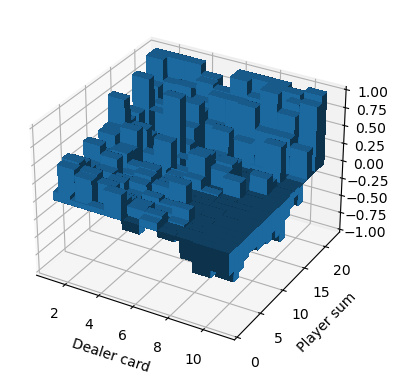

In [20]:
plot_value_function(optimal_V_Q0)

In [21]:
Q1 = monte_carlo_control(env, 100000)
optimal_Pi_Q1, optimal_V_Q1 = find_optimal_policy_and_value_function(Q1)

Episode: 10000, score: 48.110000
Episode: 20000, score: 48.980000
Episode: 30000, score: 49.536667
Episode: 40000, score: 49.952500
Episode: 50000, score: 50.386000
Episode: 60000, score: 50.578333
Episode: 70000, score: 50.838571
Episode: 80000, score: 51.037500
Episode: 90000, score: 51.074444


By increasing the number of episodes, the state value function starts to converge towards the optimal value function. 

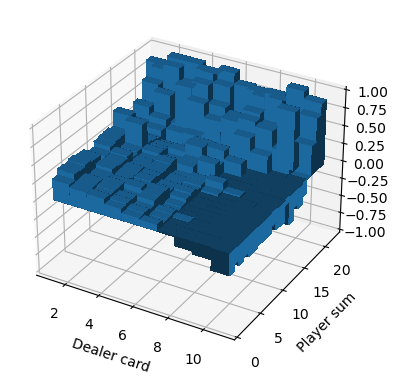

In [22]:
plot_value_function(optimal_V_Q1)

In [23]:
Q2 = monte_carlo_control(env, 1000000)
optimal_Pi_Q2, optimal_V_Q2 = find_optimal_policy_and_value_function(Q2)

Episode: 100000, score: 50.672000
Episode: 200000, score: 51.243500
Episode: 300000, score: 51.508333
Episode: 400000, score: 51.632500
Episode: 500000, score: 51.746800
Episode: 600000, score: 51.885667
Episode: 700000, score: 51.955714
Episode: 800000, score: 51.984500
Episode: 900000, score: 52.030111


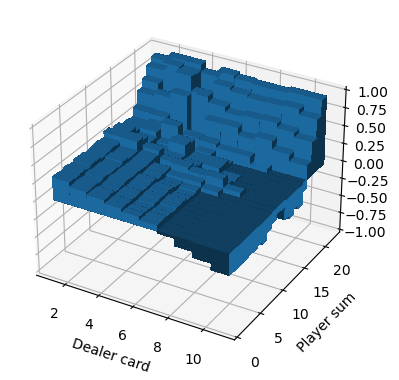

In [24]:
plot_value_function(optimal_V_Q2)

In [31]:
# doing 10 million because MC converges very slowly (and for fun)
Q3 = monte_carlo_control(env, 10000000)
optimal_Pi_Q3, optimal_V_Q3 = find_optimal_policy_and_value_function(Q3)

Episode: 1000000, score: 52.101500
Episode: 2000000, score: 52.330300
Episode: 3000000, score: 52.385833
Episode: 4000000, score: 52.410350
Episode: 5000000, score: 52.442480
Episode: 6000000, score: 52.460467
Episode: 7000000, score: 52.448771
Episode: 8000000, score: 52.460900
Episode: 9000000, score: 52.470900


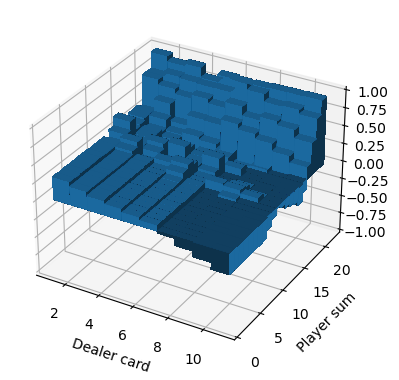

In [32]:
plot_value_function(optimal_V_Q3)

### Optimal policies
Below are the optimal policies (which action you should take given each state). MC finds that for the majority of states it is better to play it safe and stick. As we increase the number of episodes, it turns out that there are some states (when the dealer has a high card and the player has a sum around 10-15) where it is better to hit.

In [33]:
plot_policy(optimal_Pi_Q0)

Dealer     1      2      3      4      5      6      7      8      9      10
Player                                                                      
1       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
2       stick  stick  stick  stick  stick  stick  stick  stick  stick    hit
3       stick  stick  stick  stick  stick  stick  stick  stick    hit  stick
4       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
5       stick  stick  stick  stick  stick  stick  stick    hit  stick  stick
6       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
7       stick  stick  stick  stick  stick  stick    hit  stick  stick  stick
8       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
9       stick  stick  stick  stick  stick    hit    hit  stick    hit  stick
10      stick  stick  stick  stick  stick  stick  stick  stick  stick    hit
11        hit    hit  stick    hit  stick  stick  stick    hit  stick    hit

In [28]:
plot_policy(optimal_Pi_Q1)

Dealer     1      2      3      4      5      6      7      8      9      10
Player                                                                      
1       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
2       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
3       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
4       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
5       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
6       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
7       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
8       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
9       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
10      stick  stick  stick  stick  stick  stick  stick  stick  stick    hit
11      stick  stick  stick    hit  stick  stick  stick  stick    hit  stick

In [29]:
plot_policy(optimal_Pi_Q2)

Dealer     1      2      3      4      5      6      7      8      9      10
Player                                                                      
1       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
2       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
3       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
4       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
5       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
6       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
7       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
8       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
9       stick  stick  stick  stick    hit  stick    hit  stick  stick    hit
10        hit  stick  stick  stick  stick    hit    hit    hit    hit    hit
11      stick  stick  stick    hit    hit    hit    hit    hit    hit    hit

In [34]:
plot_policy(optimal_Pi_Q3)

Dealer     1      2      3      4      5      6      7      8      9      10
Player                                                                      
1       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
2       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
3       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
4       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
5       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
6       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
7       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
8       stick  stick  stick  stick  stick  stick  stick  stick  stick  stick
9       stick  stick  stick  stick    hit  stick  stick  stick    hit    hit
10      stick    hit  stick  stick    hit  stick  stick    hit    hit    hit
11      stick    hit    hit  stick    hit  stick    hit    hit    hit    hit

### Playing some episodes to test the performance of MC

In [35]:
# play an episode given an initial state and the value function
def play_episode(dealer_sum, player_sum, policy):
    terminated = False
    
    while not terminated:
        action = policy.get((dealer_sum, player_sum), 0)
        dealer_sum, player_sum, reward, terminated = env.step(
                dealer_sum, player_sum, action
            )
        
    return reward


# determine winrate by playing `count` number of episodes under the given policy
def play_episodes(policy, count=100):
    rewards = []
    for _ in range(count):
        dealer_sum = NewCard(firstCard=True).get_value()
        player_sum = NewCard(firstCard=True).get_value()

        reward = play_episode(dealer_sum, player_sum, policy)
        rewards.append(reward)

    return len([r for r in rewards if r == 1]) / count * 100

The policy trained the most obtains about 52.5% winrate (tested over 10000 games).

In [47]:
play_episodes(optimal_Pi_Q3, 10000)

52.62